In [ ]:
# libraries for deep learning.
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Activation, Dropout
from tensorflow.keras.optimizers import *
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications import xception, resnet_v2, mobilenet_v2, inception_v3
import tensorflow as tf 
import keras 

# others 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Voglio creare una cartella con all'interno test e train e all'interno di esse deve esserci benigno e maligno. 

# !pip install split-folders
# splitfolders.ratio("Class", output="Class_Train_Test", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

## ***FINE TUNING***

In this notebook in order to classify if the cancer of a breast is benign or malignant, we implement fine-tuning for different types of pre-trained networks, such as: mobilenet, xception and resnet.

For each net, the pipeline is the following:

1.  ***Preprocessing*** of the images, depending on the selected NN.
2.  ***Data augmentation*** for training set.
3.  Import chosen ***net*** with imagenet ***weights***.
4.  *Cut* the top of net and *stack* some *fully connected layers*.
5.  ***Fine tuning*** and analysis of results.

In order to analyze also the surroundings of cancer zone, we implement this pipeline for both zoomed images (*focus dataset*) in the critical region and same images but less zoomed (*focus_plus dataset*).

There are several architectures for fine-tuning tasks but we present just the best one.

We add the following new layers to net:
- Dense layer 1024 layers and relu activaction function.
- Dropout with p=0.5
- Dense layer with 64 layers and relu activation function
- Output with 1 neuron and sigmoid activation function.

First of all, we cannot say that the nets perform better on the focus plus images with respect to the focus one or viceversa: they perform quite well in both senses. The best net is the _resnet_ because it achieves, for each dataset, a good accuracy measure (~70%). It's worthwhile to mention that there isn't a lot of overfitting thanks to the data augmentation process and the dropout layer as well.   

In [ ]:
path_f = './gdrive/MyDrive/DSIM/Class_Train_Test/'
path_f_p = './gdrive/MyDrive/DSIM/Class_Train_Test_Plus/'
augm = [0.2, 15, 0.3, 0.3]

In [ ]:
def plot_hist(hist):
  plt.figure()
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','val'], loc = 'upper left')
  plt.show()  

In [ ]:
#------------------ FINE TUNING MOBILENET V2

def pipeline_mobile_net(path, augm):
  # Import training data, data augmentation, preprocessing.
  train_processing = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = mobilenet_v2.preprocess_input,
                                                                   zoom_range=augm[0],
                                                                   rotation_range=augm[1],
                                                                   width_shift_range=augm[2],
                                                                   height_shift_range=augm[3])
  train_generator = train_processing.flow_from_directory(
        directory= path + 'train',
        target_size=(224, 224),    
        color_mode="rgb",         
        batch_size=32,
        class_mode= 'binary',
        shuffle=True,
        seed=1)
  
  # Import and preprocess test.
  test_processing = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = mobilenet_v2.preprocess_input)
  test_generator = test_processing.flow_from_directory(
        directory = path + 'val',
        target_size = (224, 224),
        color_mode = "rgb",
        batch_size = 32,
        class_mode= 'binary',
        shuffle = True,
        seed = 1
  )

  # Download net and build new layers.
  base_net = mobilenet_v2.MobileNetV2(input_shape = (224,224,3),
                        weights = 'imagenet', # imagenet è un dataset: carica la rete addestrata con questo dataset.
                        include_top = False)   # ci interessa l'ultimo layer? No.
  

  for layer in base_net.layers:
    layer.trainable = False
        
  x = base_net.output

   # Add ANN.
  x = Flatten()                                 (x) 
  x = Dense(1024, activation='relu')            (x)
  x = Dropout(0.5)                              (x) 
  x = Dense(64, activation='relu')              (x)
  pred = Dense(1, activation='sigmoid')         (x)

  # Train and test. 
  net = tf.keras.Model(inputs=base_net.input, outputs=pred)

  # print(net.summary())

  net.compile(loss = keras.losses.binary_crossentropy,
            optimizer = 'adam',
            metrics=['accuracy'])

  hist = net.fit(train_generator, 
                 epochs = 20,
                 validation_data=test_generator)
  
  # return the history to plot.
  return hist

  # return last_part_net(x)

Found 2022 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Epoch 1/20
64/64 [==============================] - 31s 429ms/step - loss: 7.3536 - accuracy: 0.5356 - val_loss: 0.6928 - val_accuracy: 0.5040
Epoch 2/20
64/64 [==============================] - 26s 414ms/step - loss: 0.8179 - accuracy: 0.5190 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/20
64/64 [==============================] - 26s 412ms/step - loss: 0.7183 - accuracy: 0.5245 - val_loss: 0.6899 - val_accuracy: 0.6225
Epoch 4/20
64/64 [==============================] - 26s 408ms/step - loss: 0.6982 - accuracy: 0.5441 - val_loss: 0.6791 - val_accuracy: 0.6008
Epoch 5/20
64/64 [==============================] - 27s 417ms/step - loss: 0.6966 - accuracy: 0.5584 - val_loss: 0.6838 - val_accuracy: 0.5791
Epoch 6/20
64/64 [==============================] - 26s 411ms/step - loss: 0.6788 - accuracy: 0.5783 - val_loss: 0.6520 - val_accuracy: 0.6304
Epoch 7/20
64/64 [==============================] - 26s 413

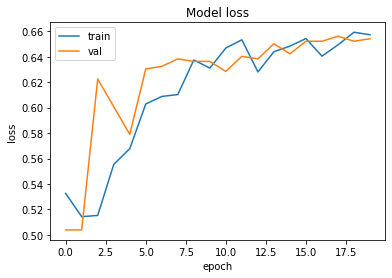

In [ ]:
hist = pipeline_mobile_net(path_f, augm)
plot_hist(hist)

Found 2022 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Epoch 1/20
64/64 [==============================] - 29s 424ms/step - loss: 6.5421 - accuracy: 0.5262 - val_loss: 0.6933 - val_accuracy: 0.4960
Epoch 2/20
64/64 [==============================] - 26s 412ms/step - loss: 0.7531 - accuracy: 0.4788 - val_loss: 0.6926 - val_accuracy: 0.4960
Epoch 3/20
64/64 [==============================] - 27s 415ms/step - loss: 0.7101 - accuracy: 0.5252 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 4/20
64/64 [==============================] - 27s 416ms/step - loss: 0.7103 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 5/20
64/64 [==============================] - 27s 415ms/step - loss: 0.7029 - accuracy: 0.4985 - val_loss: 0.6926 - val_accuracy: 0.5059
Epoch 6/20
64/64 [==============================] - 27s 415ms/step - loss: 0.7003 - accuracy: 0.5039 - val_loss: 0.6928 - val_accuracy: 0.5059
Epoch 7/20
64/64 [==============================] - 26s 419

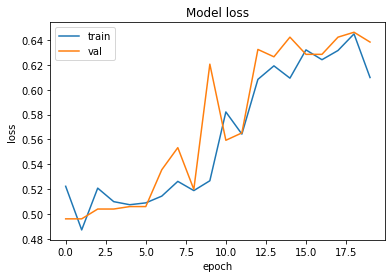

In [ ]:
hist = pipeline_mobile_net(path_f_p, augm)
plot_hist(hist)

In [ ]:
%%time
#------------------ FINE-TUNING XCEPTION

def pipeline_my_xception(path, augm):
  # Import training data, data augmentation, preprocessing.
  train_processing = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = xception.preprocess_input,
                                                                   zoom_range=augm[0],
                                                                   rotation_range=augm[1],
                                                                   width_shift_range=augm[2],
                                                                   height_shift_range=augm[3])
  train_generator = train_processing.flow_from_directory(
        directory=path + 'train',
        target_size=(299, 299),    # dimensione di default delle immagini per questa rete. 
        color_mode="rgb",          # di default per la rete.
        batch_size=32,
        class_mode="binary",
        shuffle=True,# Riordinamento casuale dei dati: importante! Ci permette di avere la garanzia che in ogni batch ci saranno tutte le classi disponibili
        seed=1)
  
  # Import and preproces test data.
  test_processing = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)
  test_generator = test_processing.flow_from_directory(
        directory = path + 'val',
        target_size = (299, 299),
        color_mode = "rgb",
        batch_size = 32,
        class_mode = "binary",
        shuffle = True,
        seed = 1
  )
  # Import net and weights.
  base_net = xception.Xception(input_shape = (299, 299, 3),
                                    weights = 'imagenet',
                                    include_top = False)

  for layer in base_net.layers:
    layer.trainable = False
        
  x = base_net.output
  # Add ANN.
  x = Flatten()                                 (x) 
  x = Dense(1024, activation='relu')            (x)
  x = Dropout(0.5)                              (x) 
  x = Dense(64, activation='relu')              (x)
  pred = Dense(1, activation='sigmoid')         (x)

  # Fine tuning.
  net = tf.keras.Model(inputs=base_net.input, outputs=pred)

  net.compile(loss=keras.losses.binary_crossentropy,
            optimizer = 'adam',
            metrics=['accuracy'])

  hist = net.fit(train_generator, 
        epochs = 20,
        validation_data=test_generator)
  
  return hist

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.7 µs


Found 2022 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Epoch 1/20
64/64 [==============================] - 52s 773ms/step - loss: 6.1904 - accuracy: 0.5064 - val_loss: 0.6924 - val_accuracy: 0.5119
Epoch 2/20
64/64 [==============================] - 49s 765ms/step - loss: 0.7636 - accuracy: 0.5097 - val_loss: 0.6869 - val_accuracy: 0.5672
Epoch 3/20
64/64 [==============================] - 49s 767ms/step - loss: 0.7106 - accuracy: 0.5459 - val_loss: 0.6771 - val_accuracy: 0.6206
Epoch 4/20
64/64 [==============================] - 49s 767ms/step - loss: 0.6997 - accuracy: 0.5402 - val_loss: 0.6804 - val_accuracy: 0.6166
Epoch 5/20
64/64 [==============================] - 49s 763ms/step - loss: 0.6962 - accuracy: 0.5842 - val_loss: 0.6807 - val_accuracy: 0.6265
Epoch 6/20
64/64 [==============================] - 49s 762ms/step - loss: 0.6810 - accuracy: 0.5689 - val_loss: 0.6797 - val_accuracy: 0.5791
Epoch 7/20
64/64 [==============================] - 49s 762

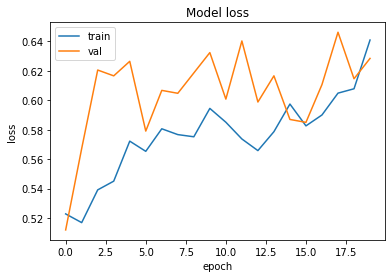

In [ ]:
hist = pipeline_my_xception(path_f, augm)
plot_hist(hist)

Found 2022 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Epoch 1/20
64/64 [==============================] - 52s 772ms/step - loss: 5.1710 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/20
64/64 [==============================] - 49s 765ms/step - loss: 0.7338 - accuracy: 0.4885 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/20
64/64 [==============================] - 49s 763ms/step - loss: 0.7124 - accuracy: 0.5315 - val_loss: 0.6930 - val_accuracy: 0.5079
Epoch 4/20
64/64 [==============================] - 49s 762ms/step - loss: 0.7052 - accuracy: 0.4912 - val_loss: 0.6930 - val_accuracy: 0.5040
Epoch 5/20
64/64 [==============================] - 49s 766ms/step - loss: 0.6909 - accuracy: 0.5037 - val_loss: 0.6827 - val_accuracy: 0.5040
Epoch 6/20
64/64 [==============================] - 49s 760ms/step - loss: 0.6908 - accuracy: 0.5034 - val_loss: 0.6861 - val_accuracy: 0.5573
Epoch 7/20
64/64 [==============================] - 49s 759

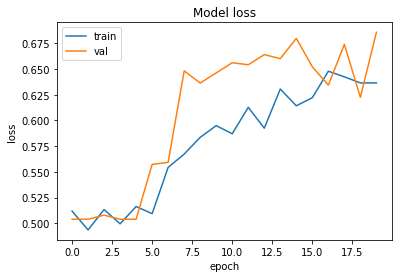

In [ ]:
hist = pipeline_my_xception(path_f_p, augm)
plot_hist(hist)

In [ ]:
#------------------ FINE-TUNING RESNET

def pipeline_my_resnet(path, augm):
  # Import, oreprocess and augmented training data.
  train_processing = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = resnet_v2.preprocess_input,
                                                                   zoom_range=augm[0],
                                                                   rotation_range=augm[1],
                                                                   width_shift_range=augm[2],
                                                                   height_shift_range=augm[3])
  train_generator = train_processing.flow_from_directory(
        directory=path + 'train',
        target_size=(299, 299),    # dimensione di default delle immagini per questa rete. 
        color_mode="rgb",          # di default per la rete.
        batch_size=32,
        class_mode="binary",
        shuffle=True,# Riordinamento casuale dei dati: importante! Ci permette di avere la garanzia che in ogni batch ci saranno tutte le classi disponibili
        seed=1)
  
  # Import and preprocess test data.
  test_processing = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= resnet_v2.preprocess_input)
  test_generator = test_processing.flow_from_directory(
        directory = path + 'val',
        target_size = (299, 299),
        color_mode = "rgb",
        batch_size = 32,
        class_mode = "binary",
        shuffle = True,
        seed = 1
  )
  # Import net and weights.
  base_net = resnet_v2.ResNet152V2(input_shape = (299, 299, 3),
                                    weights = 'imagenet',
                                    include_top = False)

  for layer in base_net.layers:
    layer.trainable = False

  x = base_net.output
  # Define ANN.      
  x = Flatten()                                 (x) 
  x = Dense(1024, activation='relu')            (x)
  x = Dropout(0.5)                              (x) 
  x = Dense(64, activation='relu')              (x)
  pred = Dense(1, activation='sigmoid')         (x)

  #-- FINE TUNING.
  net = tf.keras.Model(inputs=base_net.input, outputs=pred)

  net.compile(loss = keras.losses.binary_crossentropy,
            optimizer = 'adam',
            metrics=['accuracy'])

  hist = net.fit(train_generator, 
        epochs = 20, 
        validation_data=test_generator)
  return hist

Found 2022 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/20
64/64 [==============================] - 67s 916ms/step - loss: 10.8374 - accuracy: 0.5316 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/20
64/64 [==============================] - 55s 862ms/step - loss: 0.7605 - accuracy: 0.5253 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/20
64/64 [==============================] - 55s 864ms/step - loss: 0.7433 - accuracy: 0.5199 - val_loss: 0.6910 - val_accuracy: 0.5573
Epoch 4/20
64/64 [==============================] - 55s 863ms/step - loss: 0.7004 - accuracy: 0.5533 - val_loss: 0.6848 - val_accuracy: 0.4980
Epoch 5/20
64/64 [==============================] - 55s 864ms/step - loss: 0.7037 - accuracy: 0.5545 - val_loss: 0.6773 - val_accuracy: 0.5553
Epoch 6/20
64/64 [==============================] - 55s 863ms/step - loss: 0.7025 - accuracy: 0.5674 - val_loss: 0.6674 - val_accuracy

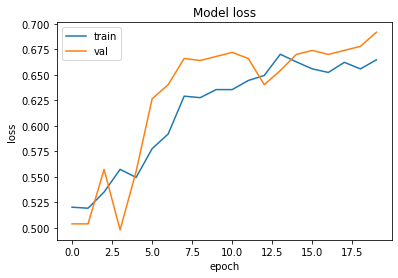

In [ ]:
hist = pipeline_my_resnet(path_f, augm)
plot_hist(hist)

Found 2022 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Epoch 1/20
64/64 [==============================] - 64s 902ms/step - loss: 6.9704 - accuracy: 0.5244 - val_loss: 0.6305 - val_accuracy: 0.6522
Epoch 2/20
64/64 [==============================] - 56s 870ms/step - loss: 0.9808 - accuracy: 0.5713 - val_loss: 0.6478 - val_accuracy: 0.6304
Epoch 3/20
64/64 [==============================] - 56s 878ms/step - loss: 0.7031 - accuracy: 0.5415 - val_loss: 0.6320 - val_accuracy: 0.6462
Epoch 4/20
64/64 [==============================] - 56s 869ms/step - loss: 0.6761 - accuracy: 0.6215 - val_loss: 0.6282 - val_accuracy: 0.6561
Epoch 5/20
64/64 [==============================] - 55s 864ms/step - loss: 0.6564 - accuracy: 0.6358 - val_loss: 0.6109 - val_accuracy: 0.6621
Epoch 6/20
64/64 [==============================] - 55s 864ms/step - loss: 0.6866 - accuracy: 0.6128 - val_loss: 0.6021 - val_accuracy: 0.6621
Epoch 7/20
64/64 [==============================] - 56s 865

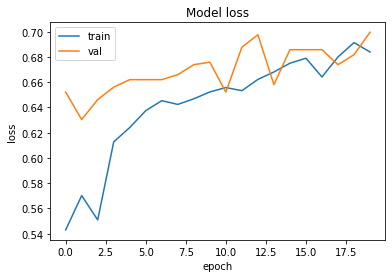

In [ ]:
hist = pipeline_my_resnet(path_f_p, augm)
plot_hist(hist)